In [29]:
import tensorflow as tf


import numpy as np
import matplotlib.pyplot as plt

from importlib import reload
import os

import cv2
import Augmentor as au

import unet_kkweon


from IPython import display
%matplotlib inline

from tqdm import tqdm_notebook

In [30]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [31]:
sess.list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]

In [32]:
path = "../data/stage_1_processed/"

### Load data

In [33]:
train_names = os.listdir(path + "train")
val_names = os.listdir(path + "val")

In [34]:
train_data = [np.load(path + "train/" + name) for name in train_names]
val_data = [np.load(path + "val/" + name) for name in val_names]

In [35]:
train_data = [np.concatenate((x,
                              np.expand_dims(cv2.morphologyEx(x[:,:,1], cv2.MORPH_GRADIENT, np.ones((2,2))),2)), -1)\
              for x in train_data ]

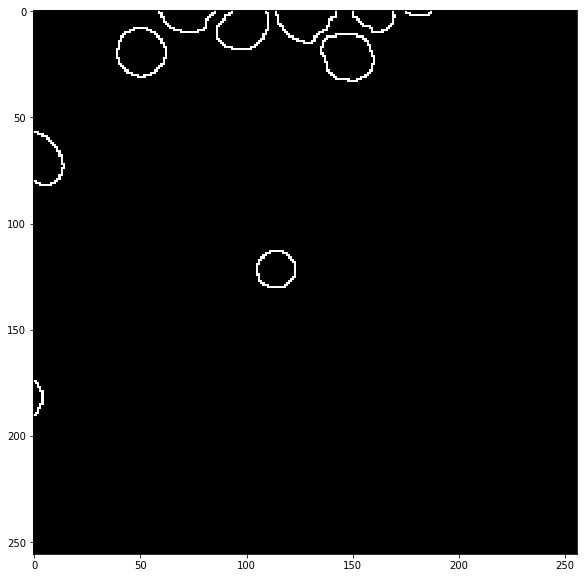

In [28]:
plt.figure(figsize = (10,10))
plt.imshow(train_data[52][:,:,2],cmap='gray')
plt.show()

### Create network and session

In [133]:
unet_kkweon = reload(unet_kkweon)

In [134]:
tf.reset_default_graph()
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))

In [135]:
x = tf.placeholder("float", shape=[None, None, None, 1])
target = tf.placeholder("float", shape=[None, None, None, 2])
training = tf.placeholder('bool')

In [136]:
with tf.variable_scope("unet"):
    unet_output = unet_kkweon.make_unet(x, training)

In [137]:
sigmoid_out = tf.nn.sigmoid(unet_output)

In [138]:
loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(target, unet_output))

In [139]:
optimizer = tf.train.AdamOptimizer(beta2=0.98)
train_step = optimizer.minimize(loss)

In [140]:
sess.run(tf.global_variables_initializer())

### Augmentation + batch_iterator

In [141]:
def mirror(im):
    shape = im.shape
    h = lambda arr: np.hstack((arr[:,(shape[1] // 2)::-1,:], arr, arr[:,:(shape[1] // 2):-1,:]))
    v = lambda arr: np.vstack((arr[shape[0] // 2::-1,:,:], arr, arr[:shape[0] // 2:-1,:,:]))

    return v(h(im))

In [142]:
def crop(im, shape):
    #shape = (int(im.shape[0] * 0.7), int(im.shape[1] * 0.7))
    #shape = (min(512, im.shape[0] - 1), min(512, im.shape[1] - 1))
    x = np.random.randint(0, im.shape[0] - shape[0])
    y = np.random.randint(0, im.shape[1] - shape[1])
    
    excerpt_x = slice(x, x+shape[0])
    excerpt_y = slice(y, y+shape[1])
    
    return im[excerpt_x, excerpt_y, :]

In [144]:
u16_up = lambda x : (x // 16 + 1) * 16
u16_d = lambda x : (x // 16) * 16

In [145]:
def get_16_im(im):
    shape = im.shape
    big_im = mirror(im)
    pos_x = shape[0] // 2
    pos_y = shape[1] // 2
    
    
    shape_shift = (u16_up(shape[0]), u16_up(shape[1]))
    
    #prediction = sess.run(sigmoid_out, feed_dict={x : np.expand_dims(big_im[x: x + shape_shift[0], y : y + shape_shift[1], :], 0), training : False})
    return big_im[pos_x: pos_x + shape_shift[0], pos_y : pos_y + shape_shift[1], :]

In [27]:
p = au.Pipeline()
#p.rotate(1, 25, 25)
p.flip_random(1)
#p.random_distortion(1, 10,10,2)
#p.skew(1)


In [147]:
g = p.keras_generator_from_array(np.expand_dims(train_data[0][:,:,:], 0) ,np.ones(1), 1, False)

In [148]:
gens = np.array([p.keras_generator_from_array(np.expand_dims(mirror(im), 0) ,np.ones(1), 1, False) for im in train_data])

In [149]:
def iterate_minibatches(x, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(x))
        np.random.shuffle(indices)
    for start_idx in range(0, len(x) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield x[excerpt]

In [150]:
train_loss = []
val_scores = []

In [151]:
epochs = 20

In [152]:
from tqdm import tqdm
import time

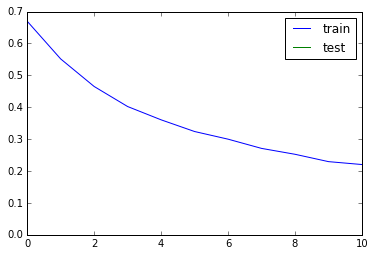

2it [00:01,  1.98it/s]


KeyboardInterrupt: 

In [153]:
for epoch in range(epochs):
    curr_loss = 0
    for i, (gen_batch) in tqdm(enumerate(iterate_minibatches(gens[:],20))):
        images = [next(g)[0][0] for g in gen_batch]
        shapes = np.concatenate(([np.array(image.shape).reshape(1, -1) for image in images]))
        
        batch_shape = (min(256, u16_d(shapes[:,0].min() - 1)), min(256, u16_d(shapes[:,1].min() - 1)))
        images = [crop(im, batch_shape) for im in images]
        
        batch_x = np.expand_dims(np.concatenate([np.expand_dims(im[:,:,0], 0) for im in images]), 3)
        batch_y = np.concatenate([np.expand_dims(im[:,:,1:], 0) for im in images])
        
        batch_loss = sess.run([train_step,loss], feed_dict={x : batch_x, target: batch_y, training : True})
        curr_loss += batch_loss[1]

    train_loss.append(curr_loss / (i + 1)) 
    
    val_score = 0
    for val_im in tqdm(val_data[:]):
        prediction = sess.run(sigmoid_out, feed_dict={x : np.expand_dims(get_16_im(val_im[:,:,:1]), 0), training : False})
        mask = prediction[0][:val_im.shape[0],:val_im.shape[1],:1]
        mask_int = (mask > 0.5).astype(int)[:,:,0].astype('uint8')
        iou = np.logical_and((mask_int == val_im[:,:,1]),val_im[:,:,1]).sum() / val_im[:,:,1].sum()
        
        val_score += iou
        
    
    
    if epoch != 0:
        if val_score < val_scores[-1]:
            save_model("../model/model_1/")
            
            
    val_scores.append(val_score / len(val_data))

    display.clear_output(wait=True)
    plt.plot(train_loss, label='train')
    plt.plot(val_scores, label='test')
    plt.legend()
    plt.show()
            
#     val_loss = sess.run(loss,  feed_dict={inp : X[4000:].reshape(-1, 100), target: y[4000:].reshape(-1, 100)})
#     val_losses.append(val_loss)
#     val_x.append(len(losses_each_n))
    
#     curr_loss == 0

        #print(batch_loss[1])

In [83]:
weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'unet')


In [82]:
def save_model(path):
    save_path = '{}/model.npz'.format(path)
    print('Saving the model into %s' %save_path)

    w_values = sess.run(weights)
    weights_dict = {w.name: w_val for w, w_val in zip(weights, w_values)}
    np.savez(save_path, **weights_dict)

In [84]:
save_model("../model/model_1/")

Saving the model into ../model/model_1//model.npz


In [125]:
j = 6

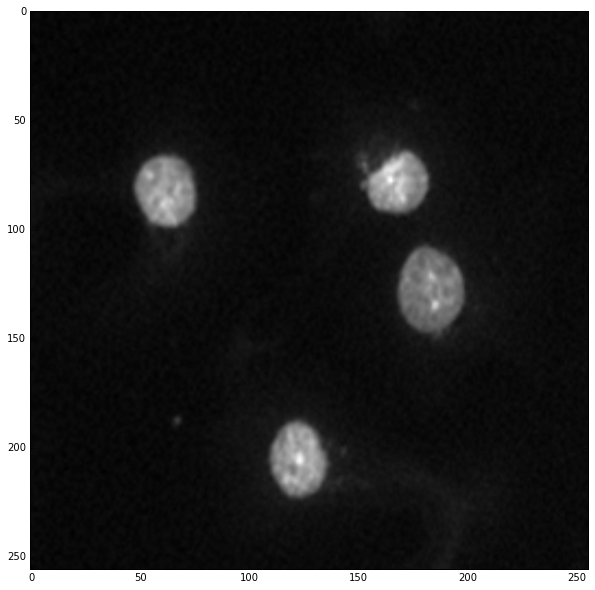

In [126]:
plt.figure(figsize = (10,10))
plt.imshow(batch_x[j,:,:,0],cmap = 'gray')
plt.show()

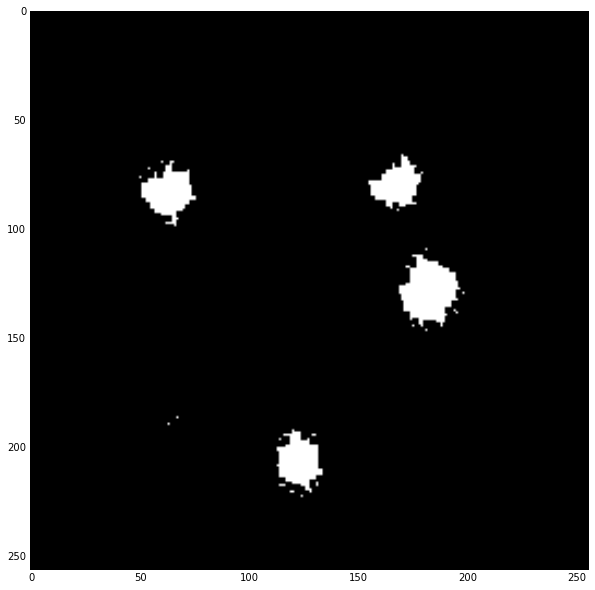

In [127]:
plt.figure(figsize = (10,10))
plt.imshow(cv2.morphologyEx(batch_y[j,:,:,0], cv2.MORPH_CLOSE, np.ones((3,3))),cmap = 'gray')
plt.show()

In [56]:
mask_int = (mask > 0.5).astype(int)[:,:,0].astype('uint8')

In [57]:
val_im[:,:,1].shape

(520, 696)

In [58]:
(mask_int == val_im[:,:,1]).sum()

238958

In [53]:
val_im[:,:,1] 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [131]:
#val_im = val_data[0]
prediction = sess.run(sigmoid_out, feed_dict={x : np.expand_dims(get_16_im(train_data[0][:,:,:1]), 0), training : False})

In [96]:
mask = prediction[0][:val_im.shape[0],:val_im.shape[1],:1]

In [491]:
(mask == val_im[:,:,1]).sum() / (mask.shape[0] * mask.shape[1])

0.0

In [99]:
prediction.shape

(1, 272, 272, 2)

In [128]:
mask[:,:,0]

array([[  3.49150121e-01,   3.40163201e-01,   3.36230755e-01, ...,
          3.36191416e-01,   3.37230474e-01,   3.36000174e-01],
       [  3.39986503e-01,   3.25537354e-01,   3.16273600e-01, ...,
          3.19549412e-01,   3.20024550e-01,   3.19973886e-01],
       [  3.31213087e-01,   3.15084696e-01,   3.08497846e-01, ...,
          3.05478901e-01,   3.10211271e-01,   3.05811077e-01],
       ..., 
       [  3.31522435e-01,   3.15526515e-01,   3.08993280e-01, ...,
          1.88918285e-08,   3.26013469e-05,   9.41519076e-08],
       [  3.31370324e-01,   3.12850416e-01,   3.10024112e-01, ...,
          1.55790549e-05,   4.15723516e-05,   3.15101170e-05],
       [  3.31933260e-01,   3.14064473e-01,   3.07358086e-01, ...,
          8.96151633e-08,   2.69302855e-05,   1.23510972e-07]], dtype=float32)

In [448]:
np.expand_dims(val_data[0][:-1,:-1,:1], 0).shape

(1, 359, 359, 1)

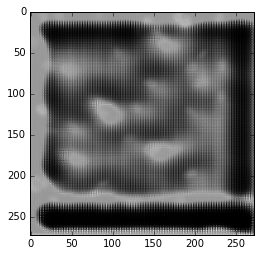

In [132]:
# n = next(gens[3])
# im = random_select(n[0][0])
#im = n[0][0]
plt.imshow(prediction[0,:,:,0],cmap = 'gray')
plt.show()

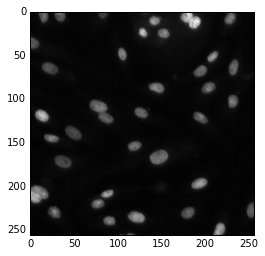

In [130]:
plt.imshow(train_data[0][:,:,0],cmap = 'gray')
plt.show()

In [444]:
val_data[0].shape

(360, 360, 2)

In [415]:
batch_y.shape

(3, 511, 511, 2)

In [411]:
np.expand_dims(np.concatenate(batch_x), 3).shape

(3, 511, 511, 1)

In [405]:
images[0].shape

(511, 511, 3)

In [436]:
batch_y[2][:,:,0]

array([[  0,   0,   0, ..., 255, 255, 254],
       [  0,   0,   0, ..., 255, 255, 254],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [428]:
batch_x[0].shape

(256, 256, 1)

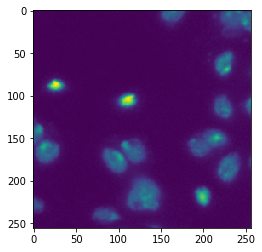

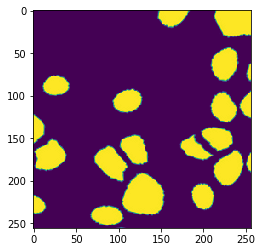

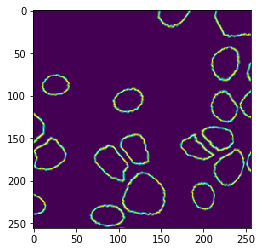

In [435]:
# n = next(gens[3])
# im = random_select(n[0][0])
#im = n[0][0]
plt.imshow(batch_x[2][:,:,0])
plt.show()
plt.imshow(batch_y[2][:,:,0])
plt.show()
plt.imshow(batch_y[2][:,:,1])
plt.show()

In [366]:
im[:,:,1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

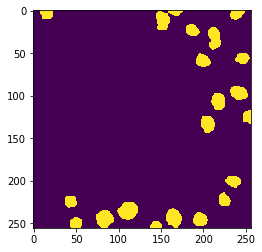

In [247]:
plt.imshow(val_data[23][:,:,1])
plt.show()

In [61]:
gr = tf.get_default_graph()
#gr = sess.graph
#gr = tf.get_default_session().graph

writer = tf.summary.FileWriter("../tf_logs", gr)

# generic unet :)

In [13]:
import tf_unet.unet as unet_module
unet_module = reload(unet_module)

In [11]:
with sess.as_default():
    unet = unet_module.Unet(channels=1)

2018-04-08 15:11:02,022 Layers 3, features 16, filter size 3x3, pool size: 2x2


In [20]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [21]:
x = tf.placeholder("float", shape=[None, None, None, 1])
y = tf.placeholder("float", shape=[None, None, None, 2])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
        
logits, variables, offset = unet_module.create_conv_net(x, keep_prob, 1, 2)

2018-04-08 15:15:32,235 Layers 3, features 16, filter size 3x3, pool size: 2x2


In [22]:
sess.run(tf.global_variables_initializer())

In [28]:
x_ = np.zeros((1,100,100,1))


In [29]:
sess.run(logits, feed_dict={x : x_, keep_prob : 1}).shape

(1, 160, 160, 2)

In [68]:
#loss = tf.reduce_mean(categorical_crossentropy(target, inp))
loss = tf.reduce_mean(tf.losses.mean_squared_error(target, out))

In [69]:
optimizer = tf.train.AdamOptimizer()
train_step = optimizer.minimize(loss)